<a href="https://colab.research.google.com/github/DinDev3/Python-Machine-Learning/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

Install packages
- pip install sklearn
- pip install pandas
- pip install quandl

---
Stock Prices


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# !pip --version
# !pip install --upgrade pip
!pip install sklearn
!pip install pandas
!pip install quandl

In [3]:
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')     # the style of the graph that will be plotted

In [4]:
# storing the tabled data received from quandl in a pandas dataframe
df = quandl.get("WIKI/GOOGL")       # https://www.quandl.com/

print(df.size)
print(df.head())

41088
              Open    High     Low  ...   Adj. Low  Adj. Close  Adj. Volume
Date                                ...                                    
2004-08-19  100.01  104.06   95.96  ...  48.128568   50.322842   44659000.0
2004-08-20  101.01  109.08  100.50  ...  50.405597   54.322689   22834300.0
2004-08-23  110.76  113.48  109.05  ...  54.693835   54.869377   18256100.0
2004-08-24  111.24  111.60  103.57  ...  51.945350   52.597363   15247300.0
2004-08-25  104.76  108.00  103.88  ...  52.100830   53.164113    9188600.0

[5 rows x 12 columns]


## Feature Engineering
Each column is a feature here.

All these columns aren't needed to find a pattern.

Relationships between features can be identified in Deep learning, but not in Regression.

We want to keep only meaningful features.

In [5]:
# creating a long list of columns that we want to have
# recreating the dataframe to contain only the mentioned columns
df = df[['Adj. Open', 'Adj. High','Adj. Low','Adj. Close','Adj. Volume']]

# print(df.head())

# defining special relationships, to use as features
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100
df['PCT_Change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

# creating a new dataframe with the special features
df = df[['Adj. Close','HL_PCT','PCT_Change','Adj. Volume']]

print(df.head())


            Adj. Close    HL_PCT  PCT_Change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.072956    0.324968   44659000.0
2004-08-20   54.322689  7.921706    7.227007   22834300.0
2004-08-23   54.869377  4.049360   -1.227880   18256100.0
2004-08-24   52.597363  7.657099   -5.726357   15247300.0
2004-08-25   53.164113  3.886792    1.183658    9188600.0


Features are kind of like attributes that make up the label.
The label is a prediction

In [6]:
# what is needed to be predicted (The column)
forecast_col = 'Adj. Close'

# fill up empty coloums(columns that don't have numbers)
df.fillna(-99999, inplace=True)

# math.ceil => round a number to the nearest whole number
# try to predict 1% of the dataframe
forecast_out = int(math.ceil(0.01*len(df)))
print(forecast_out)     # number of days used to predict

# will be using data that came 1% days ago to predict today ??

df['label'] = df[forecast_col].shift(-forecast_out)
# shifting the columns negatively (shifting columns up the spreadsheet)
# this way the forecast_col will take an Adj. Close which is 1% days into the future

print(df.head())

# df.dropna() => Drop the rows where at least one element is missing.
#       - This is done after splitting the to be predicted features set
# (inplace=True) => Keep the DataFrame with valid entries in the same variable.
# df.dropna(inplace=True)
# print(df.tail())

35
            Adj. Close    HL_PCT  PCT_Change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  8.072956    0.324968   44659000.0  69.078238
2004-08-20   54.322689  7.921706    7.227007   22834300.0  67.839414
2004-08-23   54.869377  4.049360   -1.227880   18256100.0  68.912727
2004-08-24   52.597363  7.657099   -5.726357   15247300.0  70.668146
2004-08-25   53.164113  3.886792    1.183658    9188600.0  71.219849


In ML, can't work with NA(Not available/ no numbers) data.

They need to be replaced with something.
Or get rid of an entire row (not that good in the real world, we'll be loosing data).


---

This is using the previous 1% of days from the entire dataset to predict the Adj. Close of a day (which is 1% of days into the future)



## Defining Training & Testing data

In [7]:
# defining feature and label
# feature
X = np.array(df.drop(['label'],1))    # df.drop(['label'],1) returns a new dataframe without the label column


# normalizing all the datapoints by scaling along-side all the other values
# to help with training and testing
# can be skipped for high frequency (trading), because processing time increases
X = preprocessing.scale(X)


X_lately = X[-forecast_out:]    # X values that don't have y (to be predicted) : last 1% of data
X = X[:-forecast_out]    # X values that have y values (used for training & testing) : first 99% of data

print(X)
print(X.size)

print(X_lately)
print(X_lately.size)

df.dropna(inplace=True)     # dropping the rows with missing columns

# label
y = np.array(df['label'])
y = np.array(df['label'])

print(len(X), len(y))     # making sure that X & y are equal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


[[-1.39187095  4.25846492  0.23254018  4.46712802]
 [-1.37635178  4.15018674  4.81828847  1.8207495 ]
 [-1.37423066  1.3780063  -0.79917922  1.26561472]
 ...
 [ 2.99737935 -0.42487551  0.33301614 -0.61156746]
 [ 2.7553098  -0.23328983 -0.46778619 -0.24489949]
 [ 2.55960556  2.38088557 -1.90605746 -0.49425191]]
13556
[[ 2.62040424  2.26641124  3.25839716 -0.49545744]
 [ 2.50780834  0.64357973 -1.79354019 -0.6394908 ]
 [ 2.31454846  2.66581649 -3.38541422 -0.57613569]
 [ 2.46132664  2.2334127   1.15324503 -0.41015315]
 [ 2.50451039 -0.1577593  -0.11604074 -0.60898579]
 [ 2.50288082 -0.54974983  0.27859553 -0.75717739]
 [ 2.57489253  0.19225109  1.17488957 -0.70190181]
 [ 2.64729224  0.24167535  0.50169569 -0.72903566]
 [ 2.66335519 -0.42565789  0.14545442 -0.70894085]
 [ 2.69474392  0.18451827  0.67510086 -0.74841251]
 [ 2.73416412  0.32322713  0.2951878  -0.70256205]
 [ 2.71922635 -0.2108907  -0.53369123 -0.77997427]
 [ 2.78980248 -0.2161489   0.57670541 -0.79835378]
 [ 2.85036837 -0.59

testing set size is 20% of the data

spliting training and testing data


## Creating, Training & Testing the ML Model

In [8]:
# fit the classifier

# define classifier
clf = LinearRegression()
# training
clf.fit(X_train, y_train)


# saving the model as a pickle
model_save_name = 'LinearRegression.pickle'
path = F"/content/gdrive/My Drive/Extra Learning/ML - Python/{model_save_name}" 

with open(path, 'wb') as f:    # open the file to write and take the file as variable f
  pickle.dump(clf, f)     # dump the trained classifier in f

# opening the saved ML model from a pickle
pickle_in = open(path, 'rb')     # open the file
clf = pickle.load(pickle_in)      # load the model from the saved pickle

# testing
accuracy = clf.score(X_test, y_test)

print('accuracy: ',accuracy)

accuracy:  0.9772631271736745


```
clf = svm.SVR()
```
can be used instead of the LinearRegression() classifier, to use the Support Vector Regression algorithm.

---

```
clf = LinearRegression(n_jobs=10)
```
n_jobs can be used to increase parallel processing (threading), to make training faster. It's set to 1 by default.

-1 means using all processors

---
A pickle is basically like a file.



## Predicting

*predicting based on all features*

In [9]:
forecast_set = clf.predict(X_lately)

print(forecast_set, accuracy, forecast_out)

[1098.92545985 1069.32989    1013.08429866 1055.74256474 1071.64079075
 1072.68359389 1090.38289342 1108.56976915 1113.92053737 1121.21065068
 1130.7472187  1127.50636738 1146.82517188 1163.47550415 1133.20608012
 1120.17383761 1083.27305717 1100.61157063 1112.23861313 1120.20074813
 1133.40059748 1149.1166837  1179.48236891 1184.69311593 1153.3577032
 1167.81585021 1168.2114019  1150.7579801  1115.30992555 1112.89265951
 1111.66585203 1066.63051758 1038.74112575 1066.97277833 1013.04042654] 0.9772631271736745 35


```
clf.predict()
```
Can make a prediction per value of an array/ can predict for one value

---
The stock prices for the next 1% of the days (33 days) are predicted



Since date is not a feature (in X), it needs to be calculated to be used for the x-axis of the graph.

X & y aren't necessarily x-axis & y-axis of the graph.

In this case y(price) happens to be what is needed for the y-axis. Therefore, the label(y) can directly be taken.

## Forcasting
Forcasting prices into the future depending on past data.

*Predicting based on time-series data.*

In [10]:
df['Forecast'] = np.nan     # this column is specified to be full of not a number data

# This is just to show the date on the x-axis

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400   # number of seconds per day
next_unix = last_unix + one_day


for i in forecast_set:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] +[i]

print(df.head())
print(df.tail())

            Adj. Close    HL_PCT  PCT_Change  Adj. Volume      label  Forecast
Date                                                                          
2004-08-19   50.322842  8.072956    0.324968   44659000.0  69.078238       NaN
2004-08-20   54.322689  7.921706    7.227007   22834300.0  67.839414       NaN
2004-08-23   54.869377  4.049360   -1.227880   18256100.0  68.912727       NaN
2004-08-24   52.597363  7.657099   -5.726357   15247300.0  70.668146       NaN
2004-08-25   53.164113  3.886792    1.183658    9188600.0  71.219849       NaN
            Adj. Close  HL_PCT  PCT_Change  Adj. Volume  label     Forecast
Date                                                                       
2018-03-08         NaN     NaN         NaN          NaN    NaN  1111.665852
2018-03-09         NaN     NaN         NaN          NaN    NaN  1066.630518
2018-03-10         NaN     NaN         NaN          NaN    NaN  1038.741126
2018-03-11         NaN     NaN         NaN          NaN    NaN  106

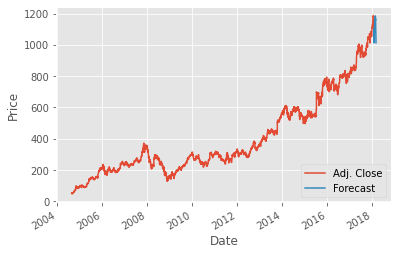

In [11]:
# plotting the graph

df['Adj. Close'].plot()   # known prices
df['Forecast'].plot()   # forecasted prices
plt.legend(loc=4)   # location of the legend on the graph is given by loc
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()